# Running a multilevel sweep parameter study with PhysiCOOL


In [1]:
%matplotlib notebook
from typing import List
from pathlib import Path

import numpy as np

from physicool.config import ConfigFileParser
from physicool.optimization import PhysiCellBlackBox
from physicool.processing import Cells

def params_updater(new_values: List[float]) -> None:
    """
    Updates the cell speed and the migration bias.

    Parameters
    ----------
    new_values: list[float]
        The parameter values for (1) the cell speed,
        and (2) the migration bias.
    """
    cell_definition_name = "cancer"

    # Read the data from the file
    xml_parser = ConfigFileParser()
    cell_data = xml_parser.read_cell_data(cell_definition_name)

    # Update values
    cell_data.motility.speed = new_values[0]
    cell_data.motility.bias = new_values[1]
    xml_parser.update_params(cell_definition_name, cell_data)

def output_processor(output_path: Path) -> np.ndarray:
    cells = Cells(time=12, storage_path=output_path)
    coordinates = cells.get_cell_positions()
    
    return np.array([coord[1] for coord in coordinates])

my_model = PhysiCellBlackBox(params_updater, output_processor)

## Generating data (optional)
We do not have any data, so we need to generate some datasets. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format!

In [2]:
params = [3.0, 0.8]
target_data = my_model.run(params)
print(target_data)

[  92.22132473  493.04321845  218.00388863  120.87424402  493.0352422
  493.02543924  493.035552    234.65332148  343.49701746  493.03402196
  493.03952064  283.52092755  493.0427071   493.03234993  335.11380217
  493.03980865  493.04430283  493.03959911  493.02808415  234.57164978
  493.0411447  -493.04121772 -493.04403113 -493.02331792 -493.0383593
 -493.04424794 -402.29950853 -493.03281724 -493.02782989 -493.04385475
 -493.0275784  -232.56945523 -493.02937343 -493.04426533 -493.02898694
 -493.03531213 -493.04439172 -493.03490282 -493.02847243 -493.03701507
 -493.02117587 -493.04104624  493.02877587  493.04090352  493.0259285
  493.04245858  493.03178391  493.03205454  493.03595872  493.03819296
  493.03164458  493.03981127  493.04115122  430.67808395  493.02685522
  493.03342376  493.03268692  291.44501759  493.03628444  334.24450279
  493.03559273  493.03374482  493.03776981  493.03850107  493.03931396
  326.88250436  493.02600811  353.39843398  493.03447102  493.03871716
  493.024

## Running the multilevel sweep pipeline

### The calibration model
First of all, **we need to define our "black-box"**. PhysiCOOL can help us do this, using `OptModel`.

`OptModel` will create a black-box function that **takes in a parameters dictionary**, **runs a PhysiCell simulation** with the updated parameter values and then **computes the metric you select** when initializing the model

You can **call this function independently**, and it will output an array with the values for the metric you choose. Here, we will be using it **inside our multilevel parameter sweep**.

<IPython.core.display.Javascript object>


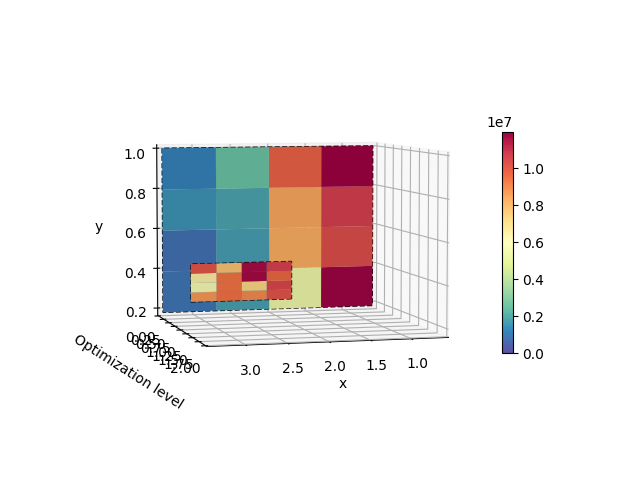

Optimal value found: 3.3299999999999996; 0.34008333333333335


In [4]:
from physicool.optimization import MultiSweep

# Create our multisweep pipeline
number_of_levels = 2
points_per_direction = 5
percent_per_direction = 0.7

ms = MultiSweep(my_model, target_data, n_levels=number_of_levels, 
                npdir=points_per_direction, ppdir=percent_per_direction)

# Select initial value for the parameter sweep
ms.set_fit_value(2.0, 0.6)
ms.set_param_bounds((0, None), (0, 1))

# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

print(f'Optimal value found: {x}; {y}')